# The q-Model in HARK and Dolo

This notebook illustrates and compares two implementations of the q-Model of investment:
- The class QMod, which will be the basis of HARK's implementation of the model.
- A Dolo model, represented in a yaml file.

Both implementations follow Christopher D. Carroll's graduate
Macroeconomics [lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Investment/qModel/).

In [1]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Import the Qmod python code from external file
# Since the Qmod class is in other folder we need to
# change the path.
import sys
sys.path.append('../')
from Qmod.Q_investment import Qmod, structural_change

## 1. Basic features of the Qmod class

We first illustrate how to create and use the main features of the Qmod class.

### Creating a model

We first create an instance of the model with the default parameter values.

In [2]:
# Create model object
Qexample = Qmod()

### Model solution and policy rule.

Now that we have created the model, we can solve it. To solve the model is to find its policy rule: a function specifying what is the optimal value for capital at $t+1$ given capital at $t$ (implicitly defining optimal investment). Solving the model also finds is steady state value of capital.

We now illustrate these two features.

The steady state value of capital is 4.298990


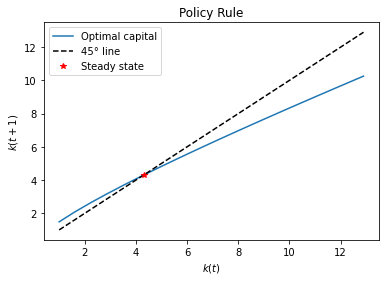

In [3]:
# Solve the model
Qexample.solve()

# Print its steady state
print('The steady state value of capital is %f' % (Qexample.kss))

# Plot policy rule
k = np.linspace(1,3*Qexample.kss,20)

plt.figure()
plt.plot(k,[Qexample.k1Func(x) for x in k], label = "Optimal capital")
plt.plot(k,k, linestyle = '--', color = 'k', label = "45° line")
plt.plot(Qexample.kss,Qexample.kss,'*r', label = "Steady state")
plt.title('Policy Rule')
plt.xlabel('$k(t)$')
plt.ylabel('$k(t+1)$')
plt.legend()
plt.show()

### Simulation of capital dynamics.

The class can also compute the dynamic adjustment of capital from a given starting level.

We can use this to see how adjustment costs affect the speed of adjustment.

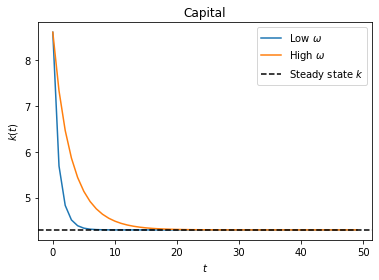

In [4]:
# Create and solve two instances, one with high and one with low adjustment costs omega
Qlow  = Qmod(omega =  0.1)
Qhigh = Qmod(omega =  0.9)

Qlow.solve()
Qhigh.solve()

# Simulate adjustment from an initial capital level
k0 = 2*Qhigh.kss
t = 50
k_low = Qlow.simulate(k0,t)
k_high = Qhigh.simulate(k0,t)

# Plot
plt.figure()
plt.plot(k_low, label = 'Low $\\omega$')
plt.plot(k_high, label = 'High $\\omega$')
plt.axhline(y = Qhigh.kss,linestyle = '--',color = 'k', label = 'Steady state ${k}$')
plt.title('Capital')
plt.xlabel('$t$')
plt.ylabel('$k(t)$')
plt.legend()
plt.show()

### Phase diagram.

The class can plot a model's phase diagram. The model has to be solved if the stable arm is to be displayed.

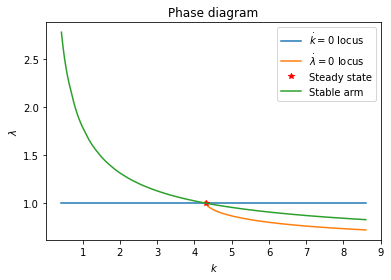

In [5]:
# Create and solve model object
Qexample = Qmod()
Qexample.solve()
# Generate its phase diagram
Qexample.phase_diagram(stableArm = True)

## 2. Structural Changes Using Qmod and Dolo

The tools in this repository can also be used to analyze the models optimal dynamic response to structural changes.

To illustrate this capabilities, I simulate the changes discussed in Christopher D. Carroll's graduate
Macroeconomics [lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Investment/qModel/):
productivity, corporate tax rate, and investment tax credit changes.

For each change I display the behavior of the model under two different assumptions:
* The change takes place at $t=0$ without notice.
* The change is announced at $t=0$ but takes place at $t=5$.

I find the optimal responses using both Qmod and the Dolo implementation of the q-Model. Thus, I first load the required tools that Dolo uses.

In [6]:
from dolo import *
import dolo.algos.perfect_foresight as pf
import dolo.algos.value_iteration as vi
import pandas as pd

Now I create a base model parametrization using both the Qmod class and the Dolo implementation.

In [7]:
# Base parameters

# Discount factor and return factor
beta = 0.98
R = 1/beta

# Tax rate
tau = 0.05

# Share of capital in production
alpha = 0.33

# Adjustment costs
omega = 1

# Investment tax credit
zeta = 0

# Depreciation rate
delta = 0.1

# Technological factor
psi = 1


## Qmod python class

Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()

## Dolo

QDolo = yaml_import("./Q_model.yaml")
# We do not pass psi, tau, or zeta since they are handled not as parameters
# but exogenous variables.
QDolo.set_calibration(R = R, alpha = alpha, delta = delta, omega = omega)

    Impossible to evaluate expression


I use "structural_change" (defined above in the preamble), a function that computes and presents optimal dynamics in face of structural changes in the Qmod implementation.

Now, I define another function to easily simulate parameter changes in the Dolo
implementation

In [8]:
def simul_change_dolo(model, k0,  exog0, exog1, t_change, T_sim):

    # The first step is to create time series for the exogenous variables
    exog = np.array([exog1,]*(T_sim - t_change))
    if t_change > 0:
        exog = np.concatenate((np.array([exog0,]*(t_change)),
                               exog),
                              axis = 0)
    exog = pd.DataFrame(exog, columns = ['R','tau','itc_1','psi'])

    # Simpulate the optimal response
    dr = pf.deterministic_solve(model = model,shocks = exog, T=T_sim,
                                verbose=True, s1 = k0)

    # Dolo uses the first period to report the steady state
    # so we ommit it.
    return(dr[1:])

### Examples:

We are now ready to simulate structural changes.

#### 2.1. An unanticipated increase in productivity

	> 1 | 0.14676772832327756 | 0
	> 2 | 0.05856537004424045 | 0
	> 3 | 0.01559187362018788 | 0
	> 4 | 0.0015131650449734524 | 0
	> 5 | 1.461287085779972e-05 | 0
	> 6 | 1.2078567035445076e-09 | 0
> System was solved after iteration 6. Residual=1.2078567035445076e-09


Text(0.5, 0, '$t$ : time')

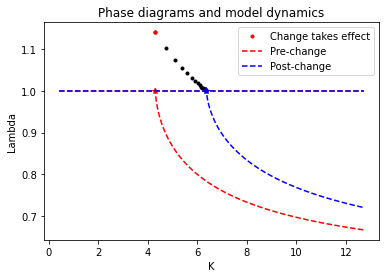

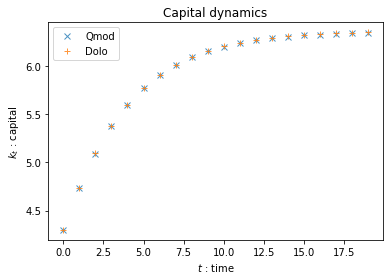

In [9]:
# Total simulation time
T = 20
# Time the change occurs
t = 0
# Initial level of capital
k0 = Qmodel.kss

# Productivity in the "new" state
psi_new = 1.3

## Qmod class

# Copy the initial model, set the higher psi and re-solve
Q_high_psi = deepcopy(Qmodel)
Q_high_psi.psi = psi_new
Q_high_psi.solve()

sol = structural_change(mod1 = Qmodel, mod2 = Q_high_psi,
                        k0 = k0, t_change = t,T_sim=T)

## Dolo

soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau,zeta,psi],
                            exog1 = [R,tau,zeta,psi_new],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol['k'], 'x', label = 'Qmod', alpha = 0.8)
plt.plot(time, soldolo['k'], '+', label = 'Dolo', alpha = 0.8)
plt.legend()
plt.title('Capital dynamics')
plt.ylabel('$k_t$ : capital')
plt.xlabel('$t$ : time')

#### 2.2. An increase in productivity announced at t=0 but taking effect at t=5

         Current function value: -78.057692
         Iterations: 17
         Function evaluations: 324
         Gradient evaluations: 54
	> 1 | 0.14676465447356568 | 0
	> 2 | 0.058552742952532766 | 0
	> 3 | 0.015573546844869002 | 0
	> 4 | 0.0015075354377829253 | 0
	> 5 | 1.4477731421269624e-05 | 0
	> 6 | 1.147427930447975e-09 | 0
> System was solved after iteration 6. Residual=1.147427930447975e-09


Text(0.5, 0, '$t$ : time')

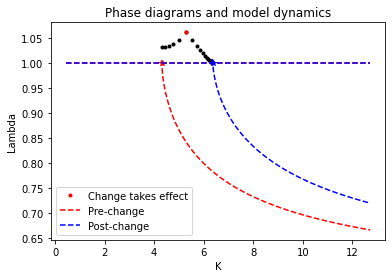

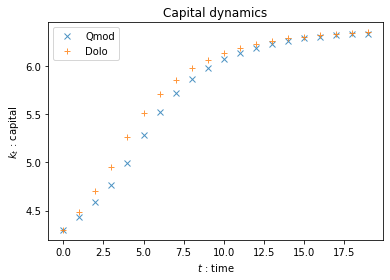

In [10]:
# Repeat the calculation now assuming the change happens at t=5
t = 5

# Qmod class
sol = structural_change(mod1 = Qmodel, mod2 = Q_high_psi,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau,zeta,psi],
                            exog1 = [R,tau,zeta,psi_new],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol['k'], 'x', label = 'Qmod', alpha = 0.8)
plt.plot(time, soldolo['k'], '+', label = 'Dolo', alpha = 0.8)
plt.legend()
plt.title('Capital dynamics')
plt.ylabel('$k_t$ : capital')
plt.xlabel('$t$ : time')

#### 2.3. An unanticipated corporate tax-cut

	> 1 | 0.08776758262738882 | 0
	> 2 | 0.02968102953159557 | 0
	> 3 | 0.0055360923186660305 | 0
	> 4 | 0.0002445252860532321 | 0
	> 5 | 4.5740636078761554e-07 | 0
> System was solved after iteration 5. Residual=4.5740636078761554e-07


Text(0.5, 0, '$t$ : time')

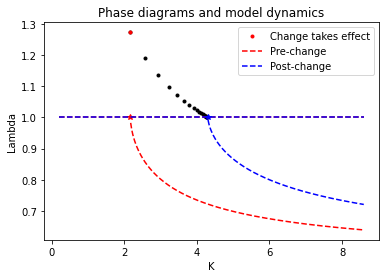

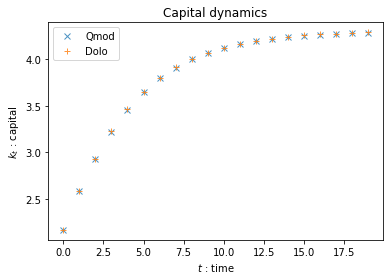

In [11]:
# Set the taxes of the 'high-tax' scenario
tau_high = 0.4
# Set time of the change
t = 0

# Qmod class

# Copy the initial model, set a higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_high
Q_high_tau.solve()

# Capital will start at it steady state in the
# high-tax scenario
k0 = Q_high_tau.kss

sol = structural_change(mod1 = Q_high_tau, mod2 = Qmodel,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau_high,zeta,psi],
                            exog1 = [R,tau,zeta,psi],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol['k'], 'x', label = 'Qmod', alpha = 0.8)
plt.plot(time, soldolo['k'], '+', label = 'Dolo', alpha = 0.8)
plt.legend()
plt.title('Capital dynamics')
plt.ylabel('$k_t$ : capital')
plt.xlabel('$t$ : time')

#### 2.4. A corporate tax cut announced at t=0 but taking effect at t=5

         Current function value: -51.110475
         Iterations: 11
         Function evaluations: 317
         Gradient evaluations: 51
	> 1 | 0.08775916530262984 | 0
	> 2 | 0.029652700258984366 | 0
	> 3 | 0.0055085146890541115 | 0
	> 4 | 0.00024043736490853007 | 0
	> 5 | 4.383555940457029e-07 | 0
> System was solved after iteration 5. Residual=4.383555940457029e-07


Text(0.5, 0, '$t$ : time')

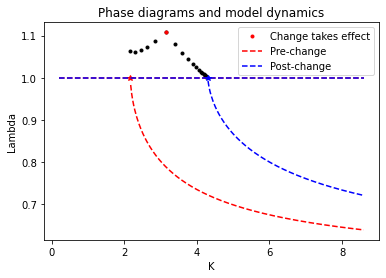

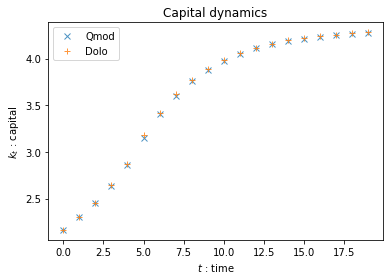

In [12]:
# Modify the time of the change
t = 5

# Qmod class
sol = structural_change(mod1 = Q_high_tau, mod2 = Qmodel,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau_high,zeta,psi],
                            exog1 = [R,tau,zeta,psi],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol['k'], 'x', label = 'Qmod', alpha = 0.8)
plt.plot(time, soldolo['k'], '+', label = 'Dolo', alpha = 0.8)
plt.legend()
plt.title('Capital dynamics')
plt.ylabel('$k_t$ : capital')
plt.xlabel('$t$ : time')

#### 2.5. An unanticipated ITC increase

	> 1 | 0.11073048294700594 | 0
	> 2 | 0.043390949890037445 | 0
	> 3 | 0.0110162005486526 | 0
	> 4 | 0.0009521405113843695 | 0
	> 5 | 7.151305653319007e-06 | 0
	> 6 | 3.5037261980619405e-10 | 0
> System was solved after iteration 6. Residual=3.5037261980619405e-10


Text(0.5, 0, '$t$ : time')

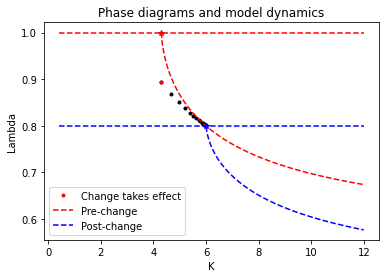

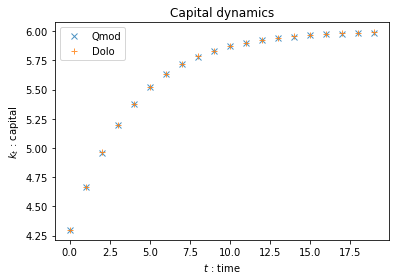

In [13]:
# Set time of the change
t=0
# Set investment tax credit in the high case
itc_high = 0.2
# Set initial value of capital
k0 = Qmodel.kss

# Qmod class

# Copy the initial model, set a higher psi and re-solve
Q_high_itc = deepcopy(Qmodel)
Q_high_itc.zeta = itc_high
Q_high_itc.solve()

sol = structural_change(mod1 = Qmodel, mod2 = Q_high_itc,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau,zeta,psi],
                            exog1 = [R,tau,itc_high,psi],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol['k'], 'x', label = 'Qmod', alpha = 0.8)
plt.plot(time, soldolo['k'], '+', label = 'Dolo', alpha = 0.8)
plt.legend()
plt.title('Capital dynamics')
plt.ylabel('$k_t$ : capital')
plt.xlabel('$t$ : time')

#### 2.6. An ITC increase announced at t=0 but taking effect at t=5

         Current function value: -60.398780
         Iterations: 20
         Function evaluations: 138
         Gradient evaluations: 23
	> 1 | 0.11070379840099309 | 0
	> 2 | 0.04329349689378226 | 0
	> 3 | 0.010892629315259583 | 0
	> 4 | 0.0009198357157441661 | 0
	> 5 | 6.578138619817153e-06 | 0
	> 6 | 2.9536340040436926e-10 | 0
> System was solved after iteration 6. Residual=2.9536340040436926e-10


Text(0.5, 0, '$t$ : time')

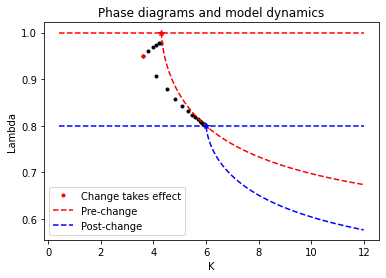

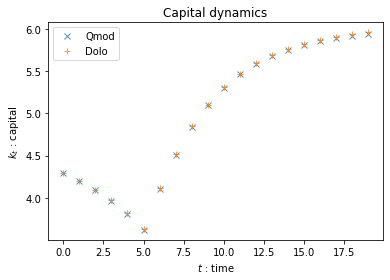

In [14]:
# Modify time of the change
t = 5

# Qmod class
sol = structural_change(mod1 = Qmodel, mod2 = Q_high_itc,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau,zeta,psi],
                            exog1 = [R,tau,itc_high,psi],
                            t_change = t+1, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol['k'], 'x', label = 'Qmod', alpha = 0.8)
plt.plot(time, soldolo['k'], '+', label = 'Dolo', alpha = 0.8)
plt.legend()
plt.title('Capital dynamics')
plt.ylabel('$k_t$ : capital')
plt.xlabel('$t$ : time')

## 3.The advantages of Dolo

Currently, Qmod represents a model in which the interest rate, taxes, and productivity are considered parameters. I compute the transitional dynamics of structural changes by approximating the final value function and then simultaneously optimizing over the transitional investment decisions. This approach works for simple changes that are not far into the future, but even then it can be imprecise and slow (see e.g. Experiment 2.2. above).

On the other hand, the Dolo implementation considers taxes, interest rates, and productivity as exogenous dynamic variables, and solves the problem of transitional dynamics using dynamic optimization tools. This makes it able to easily handle more complicated changes and paths for these variables in the future.

This section illustrates simulations of structural changes in Dolo that would be hard to handle using Qmod. The premise, as before, is that the firm is sitting in steady state and, at time $t=0$ it learns that the exogenous variables will follow the represented paths in the future. It then incorporates this information and reacts optimally.

I first define a function that, given a future path for the exogenous variables, uses Dolo to solve for the firm's optimal response and plots the results.

In [15]:
# Define a function to handle plots
def plotQmodel(model, exog, returnDF = False):
    
    # Simpulate the optimal response
    dr = pf.deterministic_solve(model = model,shocks = exog,verbose=True)
    
    # Plot exogenous variables
    ex = ['R','tau','itc_1','psi']
    fig, axes = plt.subplots(1,len(ex), figsize = (10,3))
    axes = axes.flatten()
    
    for i in range(len(ex)):
        ax = axes[i]
        ax.plot(dr[ex[i]],'.')
        ax.set_xlabel('Time')
        ax.set_ylabel(ex[i])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    fig.suptitle('Exogenous variables', fontsize=16)
    
    # Plot optimal response variables
    fig, axes = plt.subplots(2,2, figsize = (10,6))
    axes = axes.flatten()
    opt = ['k','i','lambda_1','q_1']
    
    for i in range(len(opt)):
        ax = axes[i]
        ax.plot(dr[opt[i]],'.')
        ax.set_xlabel('Time')
        ax.set_ylabel(opt[i])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    fig.suptitle('Endogenous response', fontsize=16)
    
    if returnDF:
        return(dr)

I now produce various simulations.

### 3.1. Interest rates that change multiple times.

	> 1 | 0.0889076874753193 | 0
	> 2 | 0.029602227307305773 | 0
	> 3 | 0.005452077849820047 | 0
	> 4 | 0.00024403354815494271 | 0
	> 5 | 4.887959323962576e-07 | 0
> System was solved after iteration 5. Residual=4.887959323962576e-07


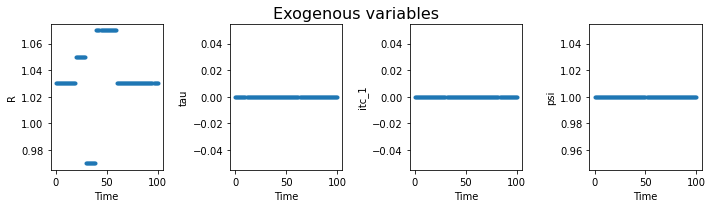

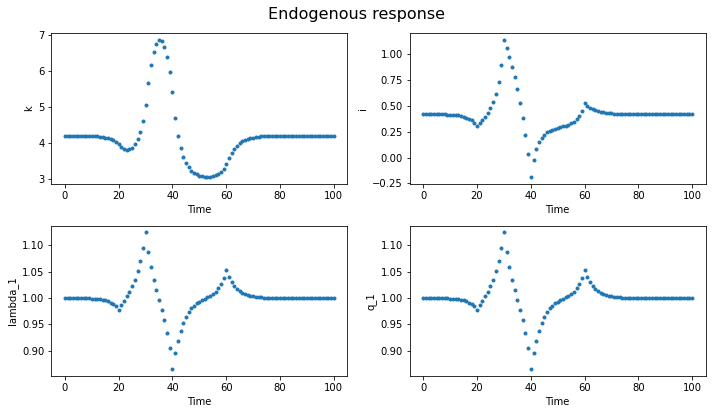

In [16]:
# First define the paths of exogenous variables

# Create empty dataframe for exog. variables
exog = pd.DataFrame(columns = ['R','tau','itc_1','psi'])

# Generate an interest rate process
exog.R = np.concatenate((np.repeat(1.03,20),
                         np.repeat(1.05,10),
                         np.repeat(0.97,10),
                         np.repeat(1.07,20),
                         np.repeat(1.03,10)))

# Leave tau at 0
exog.tau = 0
# Leave itc at 0
exog.itc_1 = 0
# Leave psi at 1
exog.psi = 1

# Solve for the optimal response and plot the results  
plotQmodel(QDolo,exog)

### 3.2. Multiple parameters changing at different times

	> 1 | 0.1100465694313103 | 0
	> 2 | 0.043393642829282375 | 0
	> 3 | 0.011987152105637833 | 0
	> 4 | 0.0014235380741938197 | 0
	> 5 | 2.3884248646521833e-05 | 0
	> 6 | 6.46493569789186e-09 | 0
> System was solved after iteration 6. Residual=6.46493569789186e-09


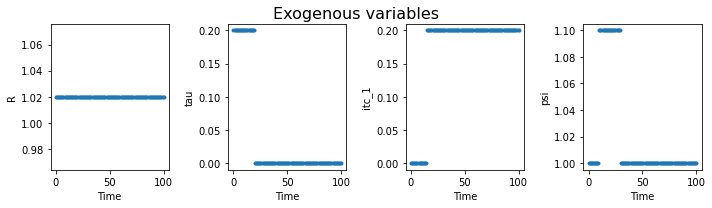

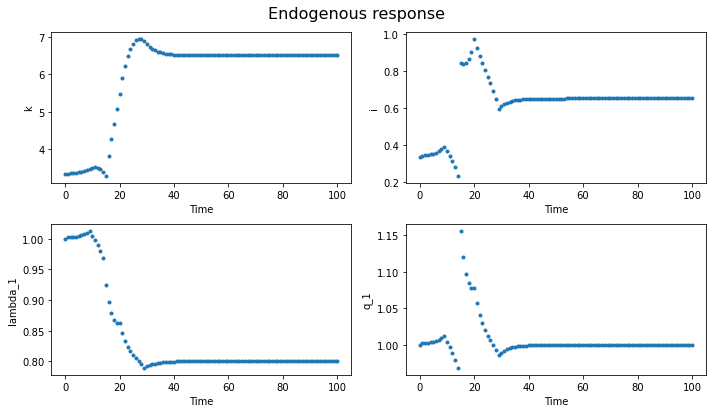

In [17]:
# Create empty dataframe for exog. variables
exog = pd.DataFrame(columns = ['R','tau','itc_1','psi'])

# Generate future tax dynamics
exog.tau = np.concatenate((np.repeat(0.2,20),
                           np.repeat(0,20)))

# Generate future itc dynamics
exog.itc_1 = np.concatenate((np.repeat(0,15),
                             np.repeat(0.2,25)))

# Generate future productivity dynamics
exog.psi= np.concatenate((np.repeat(1,10),
                          np.repeat(1.1,20),
                          np.repeat(1,10)))

# Leave R at 1.02
exog.R = 1.02

# Solve for the optimal response and plot the results  
plotQmodel(QDolo,exog)